In [120]:
#  Required packages: jplephem, matplotlib, numpy, astropy

In [121]:
import matplotlib.pyplot as plt
import numpy as np

import astropy
import astropy.coordinates
from astropy.time import Time

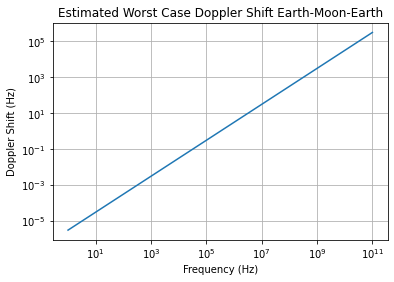

In [122]:
c = 299792458 #m/s
doppler = lambda f, v: f/((1-v**2/c**2)**(1/2)*(1 + v/c))


plt.xscale('log')
plt.yscale('log')
freq = np.geomspace(1, 10e10)
moon_recieve = doppler(freq, 460)
earth_recieve = doppler(moon_recieve, 460)
shift = (freq- earth_recieve)

plt.grid()
plt.title('Estimated Worst Case Doppler Shift Earth-Moon-Earth')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Doppler Shift (Hz)')
plt.plot(freq, shift)
plt.savefig('worst_case_estimate')


In [123]:
from astropy.utils import iers
from astropy.coordinates import get_body_barycentric,get_body_barycentric_posvel, get_body, get_moon
from astropy.coordinates import solar_system_ephemeris
from astropy.coordinates import EarthLocation
from astropy import units
from astropy.coordinates import CartesianRepresentation, CartesianDifferential, SkyCoord, GCRS
from math import acos, cos
from astropy.timeseries import TimeSeries

iers.conf.iers_auto_url = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
solar_system_ephemeris.set('jpl') 

c = 299792458 #m/s

def get_moon_position_gcrs(time):
    moon_loc, moon_vel = get_body_barycentric_posvel('moon', time)
    # TODO we should be using the point on the moon nearest to earth, rather than center of the moon
    moon_sky_coord = SkyCoord(
        representation_type = 'cartesian', differential_type=CartesianDifferential,unit='m',frame='icrs', 
        obstime =time, x = moon_loc.x, y= moon_loc.y, z = moon_loc.z, v_x = moon_vel.x, v_y = moon_vel.y, v_z = moon_vel.z)
    moon_coord = moon_sky_coord.transform_to(GCRS(obstime=time))
    return moon_coord

def earth_location_to_gcrs(earth_location_to_gcrs, time):
    pos, velocity = earth_location_to_gcrs.get_gcrs_posvel(time)
    coords = SkyCoord(
        representation_type = 'cartesian', differential_type=CartesianDifferential,unit='m',frame='gcrs', 
        obstime =time, x = pos.x, y= pos.y, z = pos.z, 
        v_x = velocity.x, v_y = velocity.y, v_z = velocity.z)
    return coords

def calculate_doppler_factor(emitter_coord, reciever_coord):
    # Calculate relative position of emitter and reciever
    delta_pos = CartesianRepresentation(x=(emitter_coord.cartesian.xyz-reciever_coord.cartesian.xyz), unit='m')
    # Calculate relative velocity
    delta_v = CartesianDifferential(d_x = (emitter_coord.velocity-reciever_coord.velocity).get_d_xyz(), unit='m/s').to_cartesian()
    # Project velocity onto velocity position vector to get velocity along path of signal
    v = (delta_pos.dot(delta_v * units.s / units.m))/(delta_pos.norm())
    # Run the results through the doppler formula
    return ((1-v/c)/(1+v/c))**(1/2)

def get_doppler(frequency, emitter, reciever, time):   
    moon_coord = get_moon_position_gcrs(time)
    emitter_coord = earth_location_to_gcrs(emitter, time)
    reciever_coord = earth_location_to_gcrs(reciever, time)
   
    shifted_e_m = frequency * calculate_doppler_factor(emitter_coord, moon_coord)
    shifted_m_e = shifted_e_m * calculate_doppler_factor(moon_coord, reciever_coord)

    return (shifted_e_m, shifted_m_e)


def get_normalized_dopplers(emitter, reciever, time):
    return get_dopplers(1, emitter, reciever, time)

def get_dopplers(frequency, emitter, reciever, times):
    y = np.empty(shape=(2,len(times)))
    for i, time in enumerate(times['time']):
        y1, y2 = get_doppler(frequency, emitter, reciever, time)
        y[0,i] = y1
        y[1,i] = y2
    return y

def normalize_dopplers(f):
    return (f-np.mean(f))/f



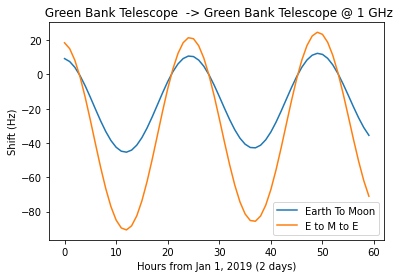

In [124]:
#Sanity Checks

emitter = EarthLocation.from_geodetic("38°25'53.6", "79°49'08.9", 0) #GBT
reciever = EarthLocation.from_geodetic("38°25'53.6", "79°49'08.9", 0) #GBT
frequency = 107.4e6
n = 60

start_time = Time('2019-01-01T00:00:00.00Z', format='isot', scale='utc')
times = TimeSeries(time_start=start_time, time_delta =units.Quantity('1h'), n_samples=n)

    
y = get_dopplers(frequency, emitter, reciever, times)
    
x = range(0, n)
plt.plot(x, y[0]-frequency, label='Earth To Moon')
plt.plot(x, y[1]-frequency, label='E to M to E')
plt.title(' Green Bank Telescope  -> Green Bank Telescope @ 1 GHz')
plt.xlabel('Hours from Jan 1, 2019 (%i days)'%(n/24))
plt.ylabel('Shift (Hz)')
plt.legend()
plt.savefig('graph.jpg')
    



0.0
1.0
2.0


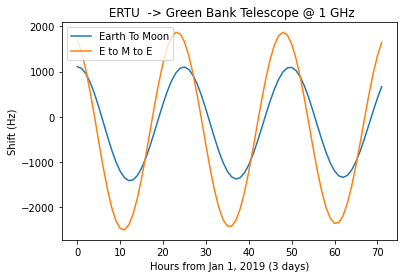

In [125]:
n = 24*3

start_time = Time('2019-01-01T00:00:00.00Z', format='isot', scale='utc')
times = TimeSeries(time_start=start_time, time_delta =units.Quantity('1h'), n_samples=n)

emitter = EarthLocation.from_geodetic(lat = "30°03'10.8",lon ="31°13'50.1", height = 0) #ERTU  Broadcasting
reciever = EarthLocation.from_geodetic(lat = "38°25'53.6",lon = "79°49'08.9", height = 0) #GBT
frequency = 1e9

y = np.empty(shape=(2,len(times)))
for i, time in enumerate(times['time']):
    if i%24 == 0:
        print(i/24)
    y1, y2 = get_doppler(frequency, emitter, reciever, time)
    y[0,i] =y1
    y[1,i] = y2
    
x = range(0, n)
plt.plot(x, y[0]-frequency, label='Earth To Moon')
plt.plot(x, y[1]-frequency, label='E to M to E')
#plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y[1]-frequency, 1))(np.unique(x)))
plt.title(' ERTU  -> Green Bank Telescope @ 1 GHz')
plt.xlabel('Hours from Jan 1, 2019 (%i days)'%(n/24))
plt.ylabel('Shift (Hz)')
plt.legend()
plt.savefig('graph.jpg')
    

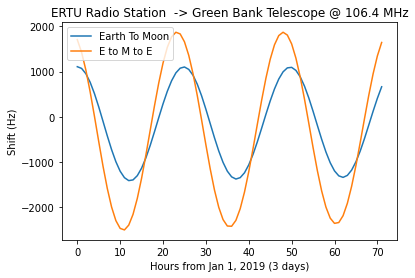

In [126]:
x = range(0, n)
plt.plot(x, y[0]-frequency, label='Earth To Moon')
plt.plot(x, y[1]-frequency, label='E to M to E')
#plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y[1]-frequency, 1))(np.unique(x)))
plt.title('ERTU Radio Station  -> Green Bank Telescope @ 106.4 MHz')
plt.xlabel('Hours from Jan 1, 2019 (%i days)'%(n/24))
plt.ylabel('Shift (Hz)')
plt.legend()              
plt.savefig('graph.jpg')

In [127]:
n = 5 * 60 * 12
timestep = '12s'
start_time = Time('2019-01-01T00:00:00.00Z', format='isot', scale='utc')


times = TimeSeries(time_start=start_time, time_delta =units.Quantity(timestep), n_samples=n)
emitter = EarthLocation.from_geodetic("30°03'10.8","31°13'50.1", 0) #ERTU  Broadcasting
reciever = EarthLocation.from_geodetic("38°25'53.6", "79°49'08.9", 0) #GBT
frequency = 107.4e6

y = np.empty(shape=(2,len(times)))
for i, time in enumerate(times['time']):
    if i%120 == 0:
        print(i/60)
    y[:, i] = get_doppler(frequency, emitter, reciever, time)


0.0
2.0
4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0
22.0
24.0
26.0
28.0
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.0
58.0


10.0
1.6666666666666667


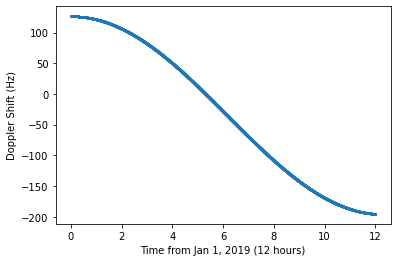

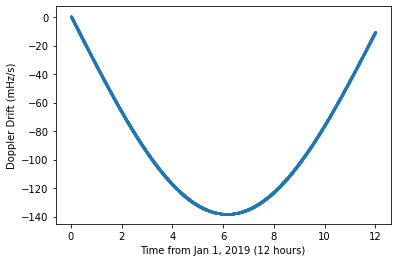

In [128]:
x= np.array(range(0,n))/5/60

accel = np.diff(y)[1]

indexes = [i for i, a in enumerate(accel) if abs(a) < .5]
xs = np.array([x[i] for i in indexes])
print(x[10 * 60 * 5])
accels = np.array([accel[i] for i in indexes])

print(x[500])

plt.scatter(x, y[1] - frequency, s=2)  # Creates the plot.  No need to save the current figure.
plt.xlabel('Time from Jan 1, 2019 (%i hours)'%(n/5/60))
plt.ylabel('Doppler Shift (Hz)')
plt.draw()  # Draws, but does not block

plt.savefig('g1.jpg')
plt.figure()  # New window, if needed.  No need to save it, as pyplot uses the concept of current figure
plt.scatter(xs, accels*1000, s=2)
plt.xlabel('Time from Jan 1, 2019 (%i hours)'%(n/5/60))
plt.ylabel('Doppler Drift (mHz/s)')
plt.draw()
plt.savefig('g2.jpg')

In [131]:
#Corrections 
# Correct for light lag for reciever position (currently assumes EM and ME happen at same time)
# Correct for moon radius (current uses center of moon)
# Determine if corrections need to be made for gravity / atmosphere / the reflection itself 

#Scope
# Show when moon is not visible
# Estimate intensity as function of frequency
# Somehow handle light reflecting off multiple parts of the moon

#General improvements
# Runtime improvements (can we batch perform calcs with numpy?)
# Determine error bounds
